In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cupy as cp
from utils.information_processing_capacity import single_input_ipc

First, we demonstrate computation of IPCs using an ESN. 
The ESN has 50 nodes and receives a uniform random input. 

In [2]:

##### Parameters for esn #####
N = 50      # Number of nodes
Two = 10000 # Washout time
T = int(1e6)# Time length except washout
p = 0.5     # Sparsity for internal weight
pin = 0.1   # Sparsity for input weight
iota = 0.1  # Input intensity
rhos = 0.1*np.arange(1,13)  # Spectral radius
#Weight
seed = 0
np.random.seed(seed)
win = (2*np.random.rand(N)-1) * (np.random.rand(N)<pin)
w = (2*np.random.rand(N,N)-1) * (np.random.rand(N,N)<p)
eig,eigv = np.linalg.eig(w)
w = w/np.max(np.abs(eig))

##### Input #####
np.random.seed(0)
zeta = 2*np.random.rand(Two+T)-1
print('zeta',zeta,zeta.shape)

zeta [ 0.09762701  0.43037873  0.20552675 ...  0.61867435 -0.30313547
 -0.51697079] (1010000,)


Here we use the legendre polynomial with uniform random input. 
To compute IPCs, we need to set `degdelays`, which is sets of degree and maximum delay and determine the search range of polynomials. 
For example, `[1,2000]` means that the maximum delay is 2000 for first-order terms (i.e., $\{\zeta_{t},\zeta_{t-1},\ldots,\zeta_{t-2000}\}$). 

In [3]:
# Parameters for IPC
poly = 'legendre'
distr = 'uniform'
degdelays = [[1,2000],[2,300],[3,50],[4,30],[5,15]]
# Class for IPC
ipc = single_input_ipc(zeta,Two,degdelays,poly=poly,distr=distr,zerobased=True)

Here we set the gpu id to `0`. 

In [4]:
gpu_id = 0
cp.cuda.Device(gpu_id).use()

Basically, we can compute IPCs through the following procedure: 
1. Compute state time series

    To compute IPCs, we need input sequence `zeta` and state time seies `x`. 
    In the following code, we obtained state time series of the ESN. 

2. Perform singular value decomposition (SVD)

    `ipc.svd(x)` performs the SVD. 
    Let `N`, `Two`, and `T` be the number of nodes, washout time, and time length except washout, respectively, and `x.shape` must be `(N,Two+T)`. 
    The SVD reduces the dimension of state $N$ to the rank $r$ ($x_t\in\mathbb{R}^{N}$ to $\hat{x}_t\in\mathbb{R}^r$). 
    We can check the rank by `ipc.rank` and the reduced state by `ipc.P`. 
    

3. Compute IPCs

    From `ipc.compute(deg,delay)`, we get IPCs `ipcs` and shuffle surrogate data `surs`. 
    However, the IPCs include numerical errors and the sum of them has a large error. 
    Therefore, using `surs` and thresholds (see Appendix B in [2]), we get truncated IPCs `truncated`. 

Also, we need to determine filenames. 
We get IPCs in pickle files (`.pkl`) and variables for IPCs in a JSON file (`.json`). 
`ipc.save_config(path)` saves the config file using the argument of `path`. 
For example, if `path = 'ipc/pkl/test'`, the config file will be saved as `ipc/pkl/test.json`
and the pickle files will be `ipc/pkl/test_ipc_X_Y.pkl`, where `X` and `Y` are degree and maximum delay, respectively. 
Please specify `pkldir` and `path`.

In [5]:
# Directory
pkldir = 'ipc/pkl'

for rho in rhos:
	print('Spectral radius',rho)
	
	# ESN
	x = np.zeros((N,Two+T))
	for t in range(1,Two+T):
		x[:,t] = np.tanh(rho*w.dot(x[:,t-1])+iota*win*zeta[t-1])

	##### Compute IPC of ESN state #####
	ipc.svd(x)
	path = '%s/state_%d_%5.3f_%5.3f_%5.3f_%5.3f'%(pkldir,N,p,pin,rho,iota)
	ipc.save_config(path)
	Ctot = 0
	for deg,delay in degdelays:
		ipcs,surs = ipc.compute(deg,delay)
		truncated = ipc.threshold(ipcs,surs,deg,delay,th_scale=1.2)
		Ctot_deg = np.sum(truncated['ipcs'].values)
		print('deg',deg,'delay',delay,'Ctot(d)',Ctot_deg)
		Ctot += Ctot_deg
	print('degs',ipc.degs,'Ctot',Ctot,'rank',ipc.rank)
	print('--------------------------------------------------------------------------------\n\n\n')


Spectral radius 0.1
{'N': 50, 'T': 1000000, 'Two': 10000, 'Nseed': 200, 'degdelays': [[1, 2000], [2, 300], [3, 50], [4, 30], [5, 15]], 'zerobased': True, 'poly': 'legendre', 'distr': 'uniform', 'thresh': 'N', 'finfo': 2.220446049250313e-16, 'rank': 16}
     degdelaysets      ipcs
1        [[1, 1]]  0.999998
2        [[1, 2]]  0.999998
3        [[1, 3]]  0.999998
4        [[1, 4]]  0.999998
5        [[1, 5]]  0.999997
6        [[1, 6]]  0.999959
7        [[1, 7]]  0.998000
8        [[1, 8]]  0.031181
9        [[1, 9]]  0.000074
1437  [[1, 1437]]  0.000048
deg 1 delay 2000 Ctot(d) 7.029249190332269
               degdelaysets      ipcs
410       [[1, 3], [1, 28]]  0.000046
1037      [[1, 1], [1, 45]]  0.000041
1084      [[1, 2], [1, 46]]  0.000043
2280      [[1, 1], [1, 67]]  0.000041
2929      [[1, 2], [1, 76]]  0.000042
3043     [[1, 39], [1, 77]]  0.000041
3086      [[1, 4], [1, 78]]  0.000040
4373      [[1, 1], [1, 93]]  0.000040
4540     [[1, 74], [1, 94]]  0.000052
4564      [[1, 3

As a result, we get IPCs `ipcs` and can check them by `ipcs`. 
For exapmle, the first-order one is 
```
     degdelaysets      ipcs
1        [[1, 1]]  0.999998
2        [[1, 2]]  0.999998
3        [[1, 3]]  0.999998
4        [[1, 4]]  0.999998
5        [[1, 5]]  0.999997
6        [[1, 6]]  0.999959
7        [[1, 7]]  0.998000
8        [[1, 8]]  0.031181
9        [[1, 9]]  0.000074
```
and the third-order one is
```
                    degdelaysets      ipcs
51                       [[3, 1]]  0.999999
53               [[1, 2], [2, 1]]  0.999824
54               [[1, 3], [2, 1]]  0.999129

```
where `degdelaysets` means a family of sets of degrees and delays for a polynomial. 
Two numbers in an inner square bracket are degree and delay (i.e., [[degree#1,delay#1],[degree#2,delay#2],...]). 
For example, in a case of `[[1,3],[2,1]]`, the target is orthogonalized polynomial of $\zeta_{t-3} \zeta_{t-1}^2$. 

We can also see the truncated IPCs by `truncated`. 
`Ctot_deg` [or `Ctot(d)`] denotes the dth-order IPC decomposition, which is the sum of dth-order truncated IPCs. 


To easily plot IPC decomposition, we prepare a method `ipc.get_indicators(npzname,paths)`.  
After specifying a `.npz` file name, we can get some indicators from the method. 
In a case of plotting IPC decomposition, we can use `ipc.ipcs_degree`, which is the dth-order IPC decomposition as a function of `rhos`. 

{'ipcs_degree': array([[7.02924919e+00, 2.18481533e-03, 8.97806211e+00, 2.08038951e-02,
        1.48914206e-02],
       [9.97890554e+00, 8.56814230e-04, 1.50251503e+01, 2.76288128e-02,
        2.37992887e-02],
       [1.22972578e+01, 4.51619167e-04, 1.97124907e+01, 3.50035233e-02,
        4.94126048e-02],
       [1.48541497e+01, 2.73357557e-04, 2.61625195e+01, 4.38608815e-02,
        6.71379450e-02],
       [1.67909528e+01, 5.09856546e-04, 3.22319563e+01, 5.01718329e-02,
        7.61135853e-02],
       [1.82680786e+01, 5.30247078e-04, 3.17558473e+01, 6.47047342e-02,
        6.73239072e-02],
       [2.06638881e+01, 0.00000000e+00, 2.93711673e+01, 3.72339060e-02,
        6.14036164e-02],
       [2.40030670e+01, 8.01231055e-04, 2.60528094e+01, 1.00778729e-02,
        4.81909098e-02],
       [2.74534690e+01, 5.14757674e-04, 2.26719770e+01, 8.14645960e-03,
        4.93508644e-02],
       [2.67426214e+01, 3.94880261e-04, 5.33967653e+00, 3.96986121e-03,
        1.04870937e-02],
       [1.2065

/tmp/ipykernel_1899075/581713860.py:17: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  ax.bar(rhos,ipc.ipcs_degree[:,i],width=0.1,bottom=bottom,label=deg,color=cm.Spectral_r((deg-1)/ipc.degmax),ec='')


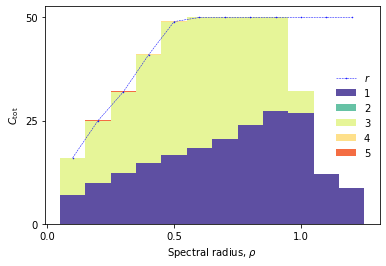

In [6]:
# Paths for loading data
paths = []
for rho in rhos:
	path = '%s/state_%d_%5.3f_%5.3f_%5.3f_%5.3f'%(pkldir,N,p,pin,rho,iota)
	paths.append(path)

# Compute various indicators from IPCs
npzname = 'ipc/npz/state_indicators_%d_%5.3f_%5.3f_%5.3f.npz'%(N,p,pin,iota)
ipc.get_indicators(npzname,paths,th_scale=1.2)

# Plot ipc decomposition
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(rhos,ipc.ranks,c='b',ls='--',marker='.',ms=1,lw=0.5,label=r'$r$')
bottom = np.zeros(rhos.shape)
for i,deg in enumerate(ipc.degs):
	ax.bar(rhos,ipc.ipcs_degree[:,i],width=0.1,bottom=bottom,label=deg,color=cm.Spectral_r((deg-1)/ipc.degmax),ec='')
	bottom += ipc.ipcs_degree[:,i]
ax.legend(loc='right',frameon=False,ncol=1)
ax.set_xticks([0,0.5,1])
ax.set_xlabel(r'Spectral radius, $\rho$')
ax.set_yticks([0,25,50])
ax.set_ylabel(r'$C_{\rm tot}$')
plt.savefig('sample1.png',dpi=300,facecolor="w",edgecolor="w")